# Hyperspace Explorer: LightGBM/Optuna Workflow

This notebook demonstrates a full machine learning workflow for tabular data, including preprocessing (accomodating for class imbalances and categorical data), hyperparameter optimization, model evaluation, and interpretation.

**Workflow overview:**
- Load and preprocess data from Excel (.xlsx)
- Define experiment configuration
- Run hyperparameter search with Optuna and LightGBM
- Analyze and visualize results
- Train and evaluate ensemble models
- Interpret model predictions with SHAP

---

# Stage 0: Import Modules
Import all required external libraries and internal modules for data processing, modeling, and visualization.

---

In [23]:
import os
import sys

# Force CPU only for all following imports and execution
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append(os.path.abspath("../src"))

import optuna
from pathlib import Path
import pandas as pd

from hyperspace_explorer.components.config import Config
from hyperspace_explorer.components.ensemble_study_runner_softvote import EnsembleStudyRunner
from hyperspace_explorer.components.lightgbm_study_runner import LightGBMStudyRunner
from hyperspace_explorer.components.study_utils import (
    suppress_noise,
    set_determinism,
    configure_matplotlib_backend,
    prepare_output_dirs,
    load_dataset,
    create_dataset,
)
from hyperspace_explorer.components.preprocess import (
    validate_features,
    set_categorical,
    create_target,
    report_missing_values,
    split_data,
)
from hyperspace_explorer.components.vizualizations import (
    plot_feature_amount_frequency_loocv,
    plot_feature_selection_frequency_loocv,
    plot_average_roc_curve_loocv,
    plot_average_roc_curve_ensemble,
    plot_shap_summary_loocv,
    plot_shap_summary_ensemble,
    plot_shap_dependence_ensemble,
    plot_shap_feature_importance_ensemble,
    plot_iterations_histogram_loocv,
    visualize_ensemble_results,
    plot_shap_decision_ensemble, plot_class_distribution,
    plot_confusion_matrix_loocv,
    plot_confusion_matrix_ensemble
)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Stage 0: Configuration, Directories, and Data Loading
Load the experiment configuration, set up output directories, and import the dataset. This stage further ensures reproducibility and organizes outputs for later analysis.

---

In [24]:
config = Config(Path(os.path.abspath("../configs/hyperspace_explorer-lgbm-1m-v1_CC_pain.json")))
suppress_noise()
rng = set_determinism(config.random_seed)
configure_matplotlib_backend(config.plt_backend)
prepare_output_dirs(config)
data = load_dataset(config.file_name)

Loading dataset from ../data/input/raw_new.xlsx...
Data Loaded. Shape: (96, 54)


# Stage 0: Data Preprocessing
Validate and preprocess the dataset:
- Check feature availability
- Define categorical columns
- Create the binary target
- Report missing values
- Split the data into training and holdout sets
- Calculate class imbalance for model weighting

---

In [25]:
# Identify existing features
existing_features = validate_features(data, config.features)
data = set_categorical(data, config.categorical_features)

# Create Binary Target Column
data = create_target(data, config.target_source, config.target)
report_missing_values(data, existing_features)

# Prepare feature and target datasets
all_X = data[existing_features].copy().sort_index(axis=1).reset_index(drop=True)
all_y = data[config.target].copy()

X, holdout_X, y, holdout_y = split_data(all_X, all_y, config.hold_out, config.random_seed)

# Calculate and report class imbalance
class_counts = y.value_counts()
plot_class_distribution(class_counts=class_counts)
config.scale_pos_weight = class_counts.get(0, 0) / class_counts.get(1, 1)
print(f"Calculated scale_pos_weight for LightGBM: {config.scale_pos_weight:.3f}")

⚠️ Column 'pain_mech_neurop' has 4 missing values.
⚠️ Column 'sleep' has 6 missing values.
⚠️ Column 'comorb' has 1 missing values.

Number of records in the training/test set: 63
Number of records in the holdout set: 8

Class distribution in the training/test set:
CC_pain_cluster
0    38
1    25
Name: count, dtype: int64

Class distribution in the holdout set:
CC_pain_cluster
0    5
1    3
Name: count, dtype: int64
Class distribution in training set: {0: 38, 1: 25}
Calculated scale_pos_weight for LightGBM: 1.520


# Stage 1: Hyperspace Exploration
Perform hyperparameter optimization using Optuna and LightGBM with leave-one-out cross-validation (LOOCV). This stage systematically explores the parameter space to identify optimal model settings.

---

In [26]:
loocv_runner = LightGBMStudyRunner(config, X, y)

loocv_runner.create_study()
loocv_runner.explore_hyperspace()
loocv_runner.summarize_results()

/app/MLmodel/src/hyperspace_explorer/components/lightgbm_study_runner.py:45: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler = optuna.samplers.QMCSampler(


  0%|          | 0/10000 [00:00<?, ?it/s]

📈 Number of finished trials: 10000
✅ Number of successful trials: 5228


# Analyze Hyperspace Exploration Results
Summarize and visualize the results of the hyperparameter search:
- Review model scores and selected features
- Analyze parameter distributions
- Visualize feature selection frequencies and coverage

---

In [27]:
loocv_runner.summarize_scores()
loocv_runner.show_selected_features()
categorical_param_df, numerical_param_df = loocv_runner.analyze_parameters()
feature_stats_df, final_features = loocv_runner.analyze_feature_rankings()


🏅 Top Trials by Objective Scores:


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
0,3952,1.0,1.0,1.0
1,4562,1.0,1.0,1.0
2,5964,1.0,1.0,1.0
3,6558,1.0,1.0,1.0
4,7272,1.0,1.0,1.0
5,9604,1.0,1.0,1.0



🧠 Selected Features for Top Trials:


,Trial ID,0,1,2,3,4,5,6,7,8,9
0,3952,pain_int,expec,self_eff,pain_mech_neurop,bmi,pain_mech_nocipl,sleep,None,None,None
1,4562,pain_int,pain_mech_neurop,expec,bmi,self_eff,pain_mech_nocipl,psy_fac,age,sleep,gen_health
2,5964,pain_int,pain_mech_neurop,expec,bmi,self_eff,pain_mech_nocipl,psy_fac,age,sleep,gen_health
3,6558,pain_int,pain_mech_neurop,expec,bmi,self_eff,pain_mech_nocipl,psy_fac,age,sleep,gen_health
4,7272,pain_int,pain_mech_neurop,expec,bmi,self_eff,pain_mech_nocipl,psy_fac,age,sleep,gen_health
5,9604,pain_int,pain_mech_neurop,expec,bmi,self_eff,pain_mech_nocipl,psy_fac,age,sleep,gen_health



🔣 Unique Values for Categorical Parameters:


,grow_policy
0,depthwise
1,leaf



📈 Min/Max Range of Numerical Parameters:


,subsample,learning_rate,feature_fraction,max_depth,min_child_weight
min,0.200000,0.10000,0.200000,3,2
max,0.999902,0.99989,0.999902,9,6



📊 Feature Selection Stats Across Trials:


,Feature,Frequency,RankSum,RankSum_Per_Frequency
0,pain_int,5188,5425,1.045682
1,pain_mech_neurop,4835,10475,2.166494
2,expec,4477,14497,3.238106
3,psy_fac,4063,16021,3.943145
4,pain_area,2744,15081,5.495991
5,bmi,2885,16719,5.795147
6,sleep,3257,19256,5.912189
7,self_eff,2342,14192,6.059778
8,pain_mech_nocipl,1798,12778,7.106785
9,smoke,1011,8014,7.926805



📐 RankSum_Per_Frequency Cutoff (coverage=80%): 9

🏁 Final Feature Set (after cutoff):


,Feature,Frequency,RankSum,RankSum_Per_Frequency
0,pain_int,5188,5425,1.045682
1,pain_mech_neurop,4835,10475,2.166494
2,expec,4477,14497,3.238106
3,psy_fac,4063,16021,3.943145
4,pain_area,2744,15081,5.495991
5,bmi,2885,16719,5.795147
6,sleep,3257,19256,5.912189
7,self_eff,2342,14192,6.059778
8,pain_mech_nocipl,1798,12778,7.106785
9,smoke,1011,8014,7.926805


🧠 Final Selected Features: ['pain_int', 'pain_mech_neurop', 'expec', 'psy_fac', 'pain_area', 'bmi', 'sleep', 'self_eff', 'pain_mech_nocipl', 'smoke']


In [28]:
trial_df_long = (
    pd.DataFrame([
        (trial.number, feat)
        for trial in loocv_runner.study.trials
        if trial.state == optuna.trial.TrialState.COMPLETE
        for feat in trial.user_attrs["selected_features"]
    ], columns=["Trial", "Feature"])
)

frequency_df_sorted, feature_amount_freq, cumulative_percentages, selected_features_coverage_pct = (
    loocv_runner.analyze_feature_frequencies(
        trial_df_long=trial_df_long,
        feat_stats_df=feature_stats_df,
        final_features=final_features
    )
)


📊 Frequency of number of features selected per trial:
1      56
2     347
3     470
4     342
5     560
6     690
7     911
8     539
9     460
10    375
11    358
12     81
13     29
14     10
Name: count, dtype: int64

📈 Cumulative % of feature set sizes across trials:
1       1.071155
2       7.708493
3      16.698546
4      23.240245
5      33.951798
6      47.149962
7      64.575363
8      74.885233
9      83.684009
10     90.856924
11     97.704667
12     99.254017
13     99.808722
14    100.000000
Name: count, dtype: float64

✅ Coverage of selected features across all feature picks: 100.00%

📋 Top features sorted by frequency and selection status:


,Feature,Frequency,RankSum,RankSum_Per_Frequency,Selected,Cumulative_Frequency,Cumulative_Percentage
0,pain_int,5188,5425,1.045682,True,5188,15.914110
1,pain_mech_neurop,4835,10475,2.166494,True,10023,30.745399
2,expec,4477,14497,3.238106,True,14500,44.478528
3,psy_fac,4063,16021,3.943145,True,18563,56.941718
6,sleep,3257,19256,5.912189,True,21820,66.932515
5,bmi,2885,16719,5.795147,True,24705,75.782209
4,pain_area,2744,15081,5.495991,True,27449,84.199387
7,self_eff,2342,14192,6.059778,True,29791,91.383436
8,pain_mech_nocipl,1798,12778,7.106785,True,31589,96.898773
9,smoke,1011,8014,7.926805,True,32600,100.000000


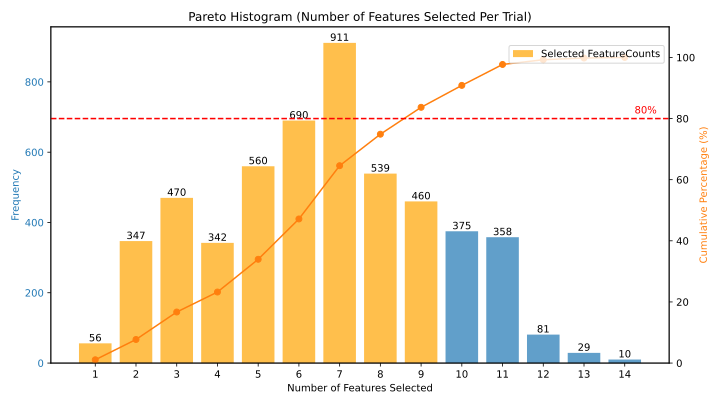

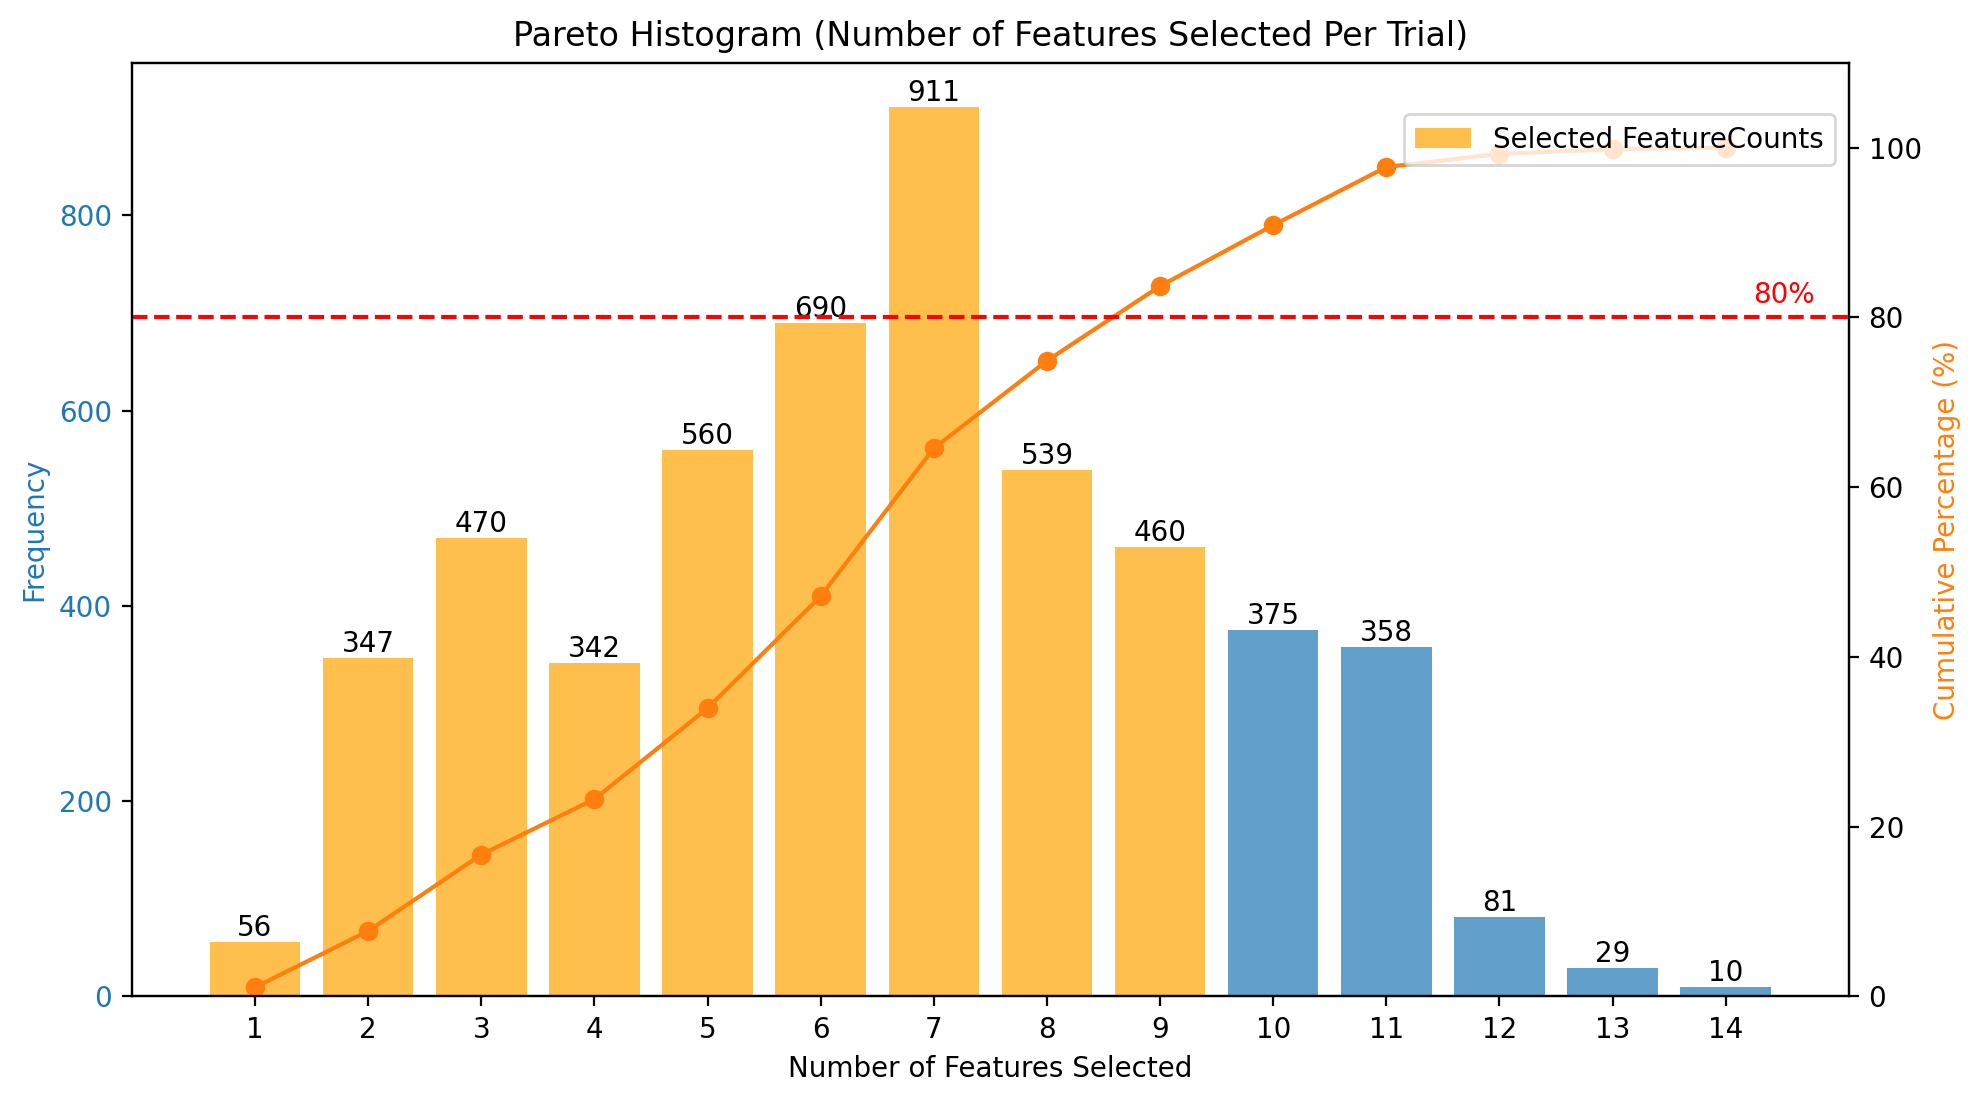

In [29]:
# Visualize feature amount frequency and cumulative percentages
plot_feature_amount_frequency_loocv(
    feature_amount_freq=feature_amount_freq,
    cumulative_percentages=cumulative_percentages,
    x_positions=feature_amount_freq.index,
    config=config,
    threshold_pct=config.feat_count_cov
)
# This plot shows how often different numbers of features are selected across LOOCV trials, and the cumulative percentage. Useful for understanding feature selection stability.

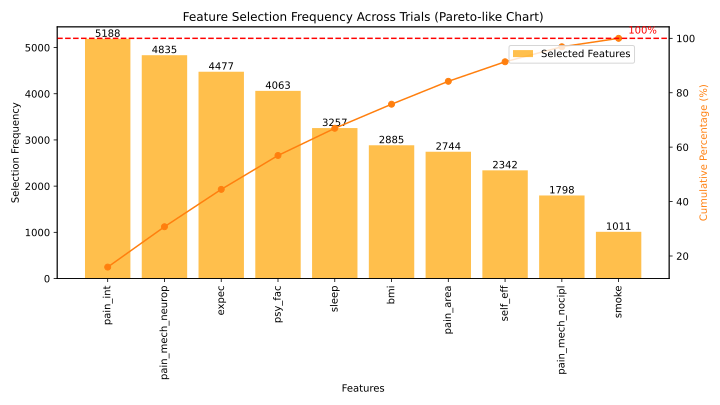

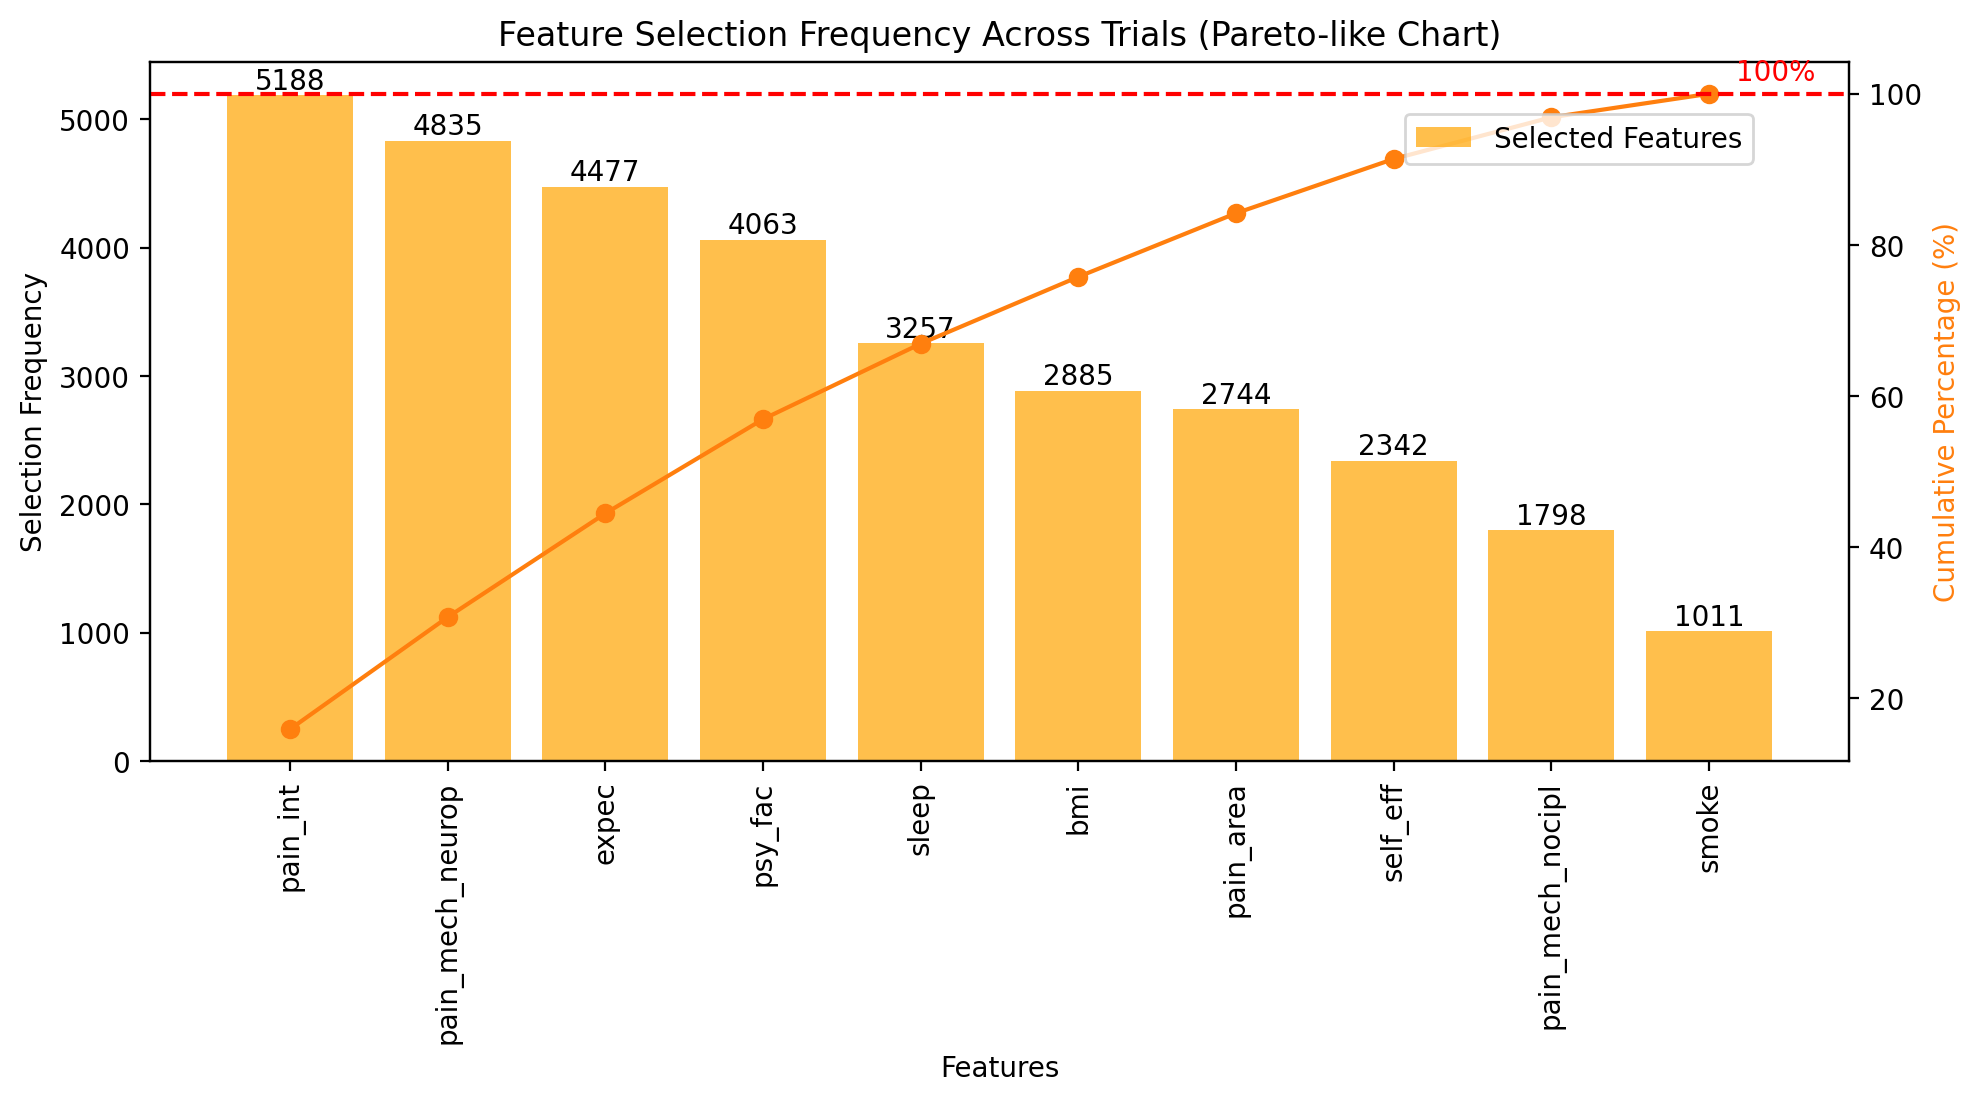

In [30]:
plot_feature_selection_frequency_loocv(
    frequency_df_sorted=frequency_df_sorted,
    selected_features_coverage_pct=selected_features_coverage_pct,
    config=config
)
# This plot shows how frequently each feature was selected across all LOOCV trials, and the overall coverage. It helps identify consistently important features.

# Stage 2: Final LOOCV Study
Conduct a final LOOCV study using the best features and parameters identified. Summarize performance metrics and generate detailed classification reports for robust model evaluation.

---

In [31]:
final_study = loocv_runner.explore_final_hyperspace(
    data=X[final_features],
    target=y,
)

  0%|          | 0/200 [00:00<?, ?it/s]

🧪 Final Study Results
📊 Total trials run: 200
✅ Successful trials: 200


In [32]:
final_scores_df = loocv_runner.get_final_scores_df(final_study)
best_final_params, best_trial = loocv_runner.get_best_final_trial_params(final_study, final_scores_df)

# Print aggregate metrics
loocv_runner.summarize_final_classification_report(final_study, y)

# Print full report across all best predictions
loocv_runner.summarize_combined_report(final_study, y)

📋 Final Best Trials (sorted):


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
2,192,0.973684,0.960000,0.986316
0,113,0.950000,0.913043,0.994737
1,166,0.950000,0.913043,0.994737



🏆 Best Final Trial ID: 192
⚙️ Best Final Params:
    verbose: -1
    objective: binary
    n_jobs: 1
    num_threads: 1
    tree_learner: serial
    deterministic: True
    seed: 42
    feature_fraction_seed: 42
    data_random_seed: 42
    max_bin: 255
    metric: binary_logloss
    boosting_type: gbdt
    is_unbalance: False
    scale_pos_weight: 1.52
    force_col_wise: True
    subsample: 0.846638933439642
    learning_rate: 0.8745629622445603
    feature_fraction: 0.2781281529127237
    max_depth: 7
    min_child_weight: 5
    grow_policy: depthwise

📊 Average Classification Report Across Best Trials:
              precision    recall  f1-score   support

           0      0.928     0.991     0.958        38
           1      0.987     0.880     0.929        25
    accuracy                          0.947        63
   macro avg      0.957     0.936     0.943        63
weighted avg      0.951     0.947     0.946        63

📈 Overall Classification Report Across All Best Trials:
   

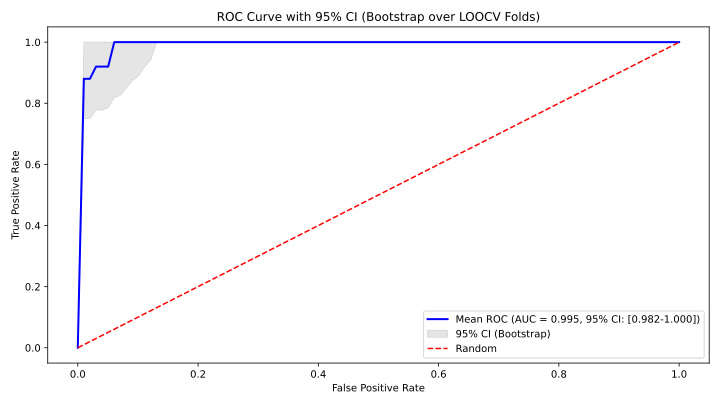

In [33]:
# Visualize average ROC curve for LOOCV
plot_average_roc_curve_loocv(final_study, y, config)

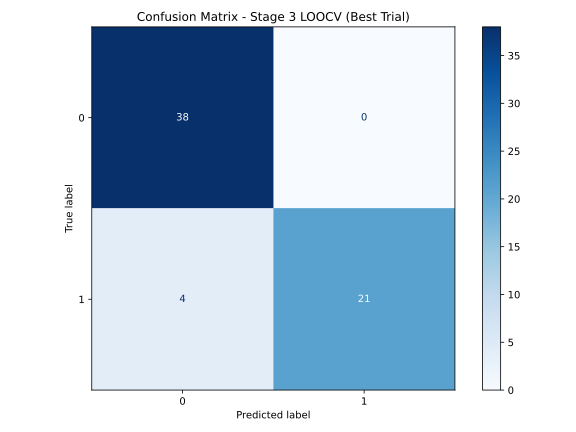

In [34]:
# Visualize confusion matrix for LOOCV
plot_confusion_matrix_loocv(final_study, y, config)

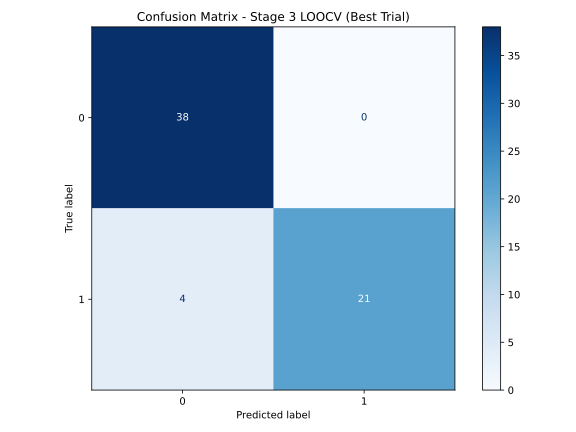

In [35]:
# Visualize confusion matrix for LOOCV
plot_confusion_matrix_loocv(final_study, y, config)

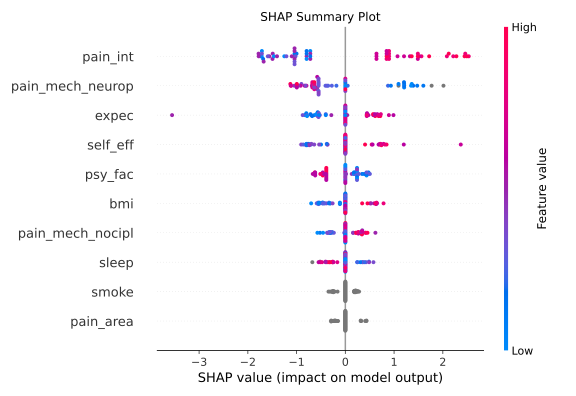

In [36]:
# Visualize SHAP summary for LOOCV
plot_shap_summary_loocv(best_trial, final_features, X, rng, config)

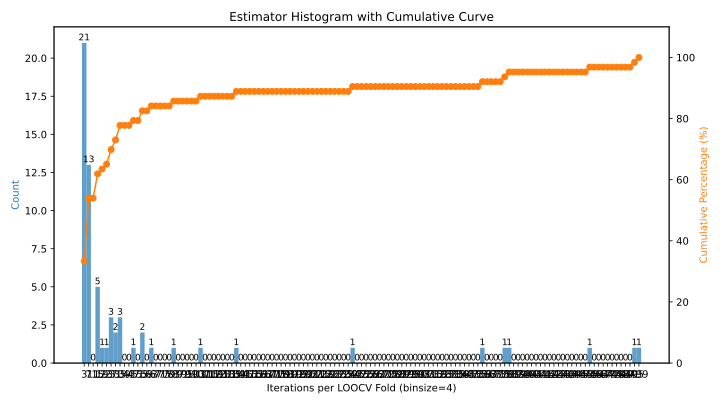

In [37]:
# Visualize iterations histogram for LOOCV
plot_iterations_histogram_loocv(best_trial, config)


# Stage 3: Ensemble Training and Evaluation
Train an ensemble of models using stratified k-fold cross-validation. Aggregate predictions via majority voting on the holdout set, and visualize ensemble performance and feature importance for comprehensive assessment.

---

In [38]:
ensemble_runner = EnsembleStudyRunner(config=config,
                                      numerical_param_df=numerical_param_df,
                                      categorical_param_df=categorical_param_df)

ensemble_result = ensemble_runner.run_final_study(X, y, final_features)

  0%|          | 0/200 [00:00<?, ?it/s]

Number of finished trials:  200


,Trial ID,F1_Score_0,F1_Score_1,ROC_AUC
4,161,0.901111,0.829596,0.902143
3,100,0.861667,0.754444,0.906429
2,64,0.866715,0.729365,0.908571
6,167,0.866715,0.729365,0.908571
0,21,0.832267,0.698767,0.914643
1,62,0.832267,0.698767,0.914643
5,165,0.832267,0.698767,0.914643
7,194,0.832267,0.698767,0.914643


Best Trial ID: 161
  Final Features: ['pain_int', 'pain_mech_neurop', 'expec', 'psy_fac', 'pain_area', 'bmi', 'sleep', 'self_eff', 'pain_mech_nocipl', 'smoke']
  Params:
    verbose: -1
    objective: binary
    n_jobs: 1
    num_threads: 1
    tree_learner: serial
    deterministic: True
    seed: 42
    feature_fraction_seed: 42
    data_random_seed: 42
    max_bin: 255
    metric: binary_logloss
    boosting_type: gbdt
    is_unbalance: False
    scale_pos_weight: 1.52
    force_col_wise: True
    subsample: 0.7477180697645338
    learning_rate: 0.6927519022133424
    feature_fraction: 0.25694396675173203
    max_depth: 5
    min_child_weight: 2
    grow_policy: depthwise
Estimators:  [4, 20, 16, 27, 5]

Average Classification Report Across Folds:
              precision    recall  f1-score   support
           0      0.885     0.925     0.901         8
           1      0.887     0.800     0.830         5

    accuracy                          0.876        13
   macro avg      0.88

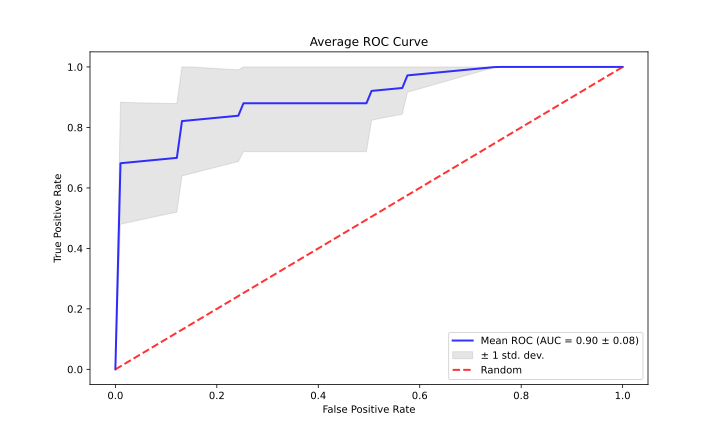

In [39]:
# Visualize average ROC curve for ensemble
plot_average_roc_curve_ensemble(ensemble_result["best_trial"], config)
# This plot shows the average ROC curve for the ensemble model, summarizing its discrimination performance across folds.

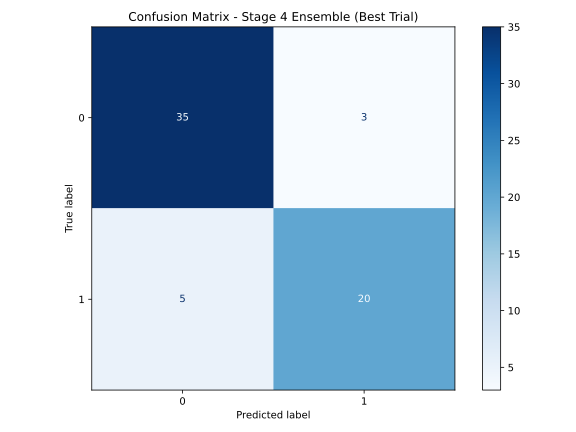

In [40]:
# Visualize confusion matrix for ensemble
plot_confusion_matrix_ensemble(ensemble_result["best_trial"], config)

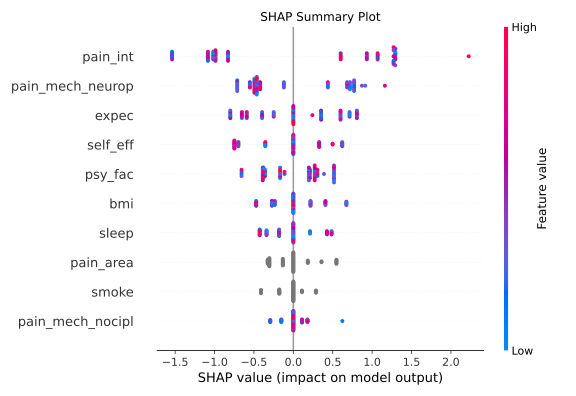

In [41]:
# Visualize SHAP summary for ensemble best trial
plot_shap_summary_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, rng)
# This plot provides a global view of feature importance and the direction of their effects for the ensemble model.

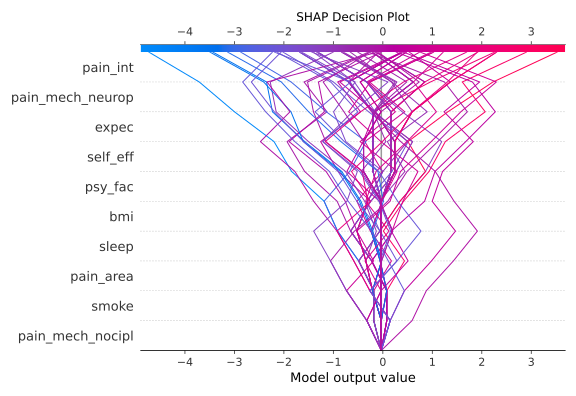

In [42]:
# Visualize SHAP decision plot for ensemble best trial
plot_shap_decision_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config)
# This plot shows how individual features contribute to the model's decision for each sample in the ensemble, helping to interpret model predictions.

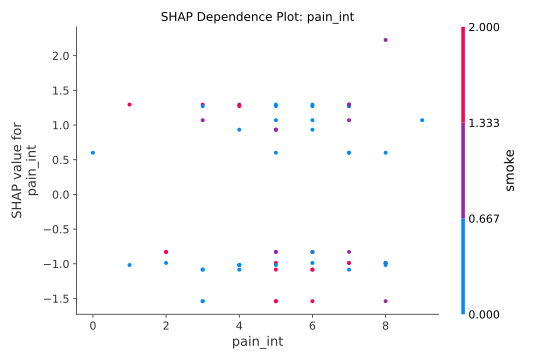

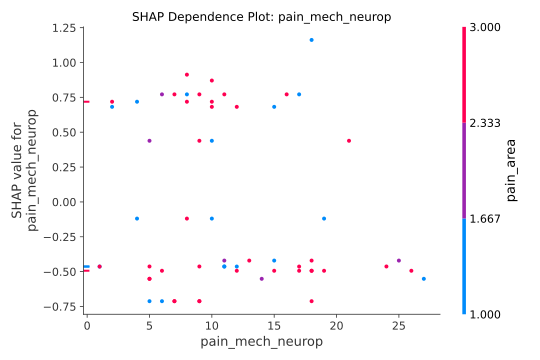

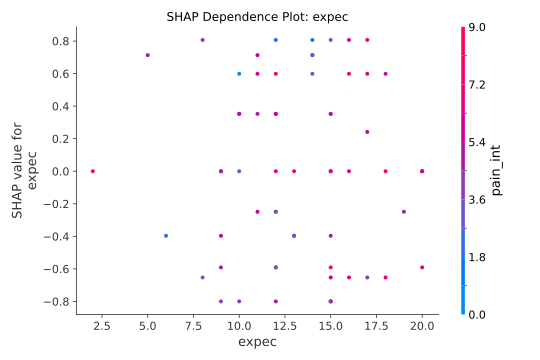

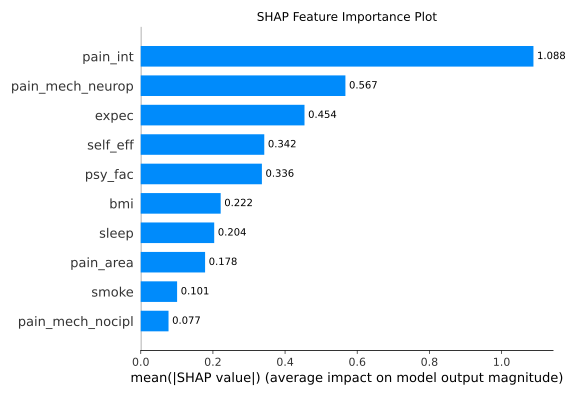

In [43]:
plot_shap_dependence_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, max_features=3)
plot_shap_feature_importance_ensemble(ensemble_result["best_trial"], X[final_features], final_features, config, rng)

  0%|          | 0/8 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.33      0.33      0.33         3

    accuracy                           0.50         8
   macro avg       0.47      0.47      0.47         8
weighted avg       0.50      0.50      0.50         8



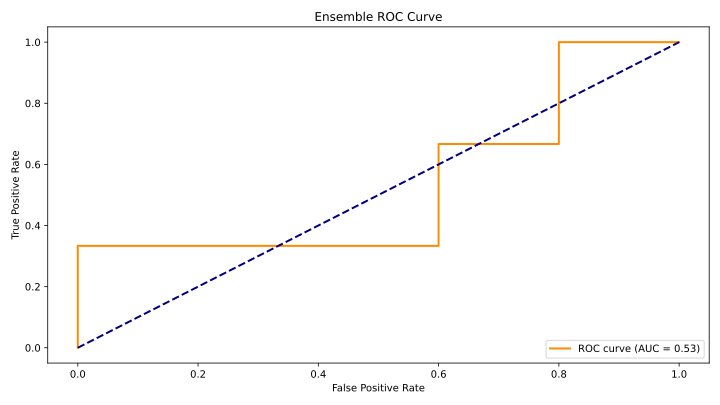

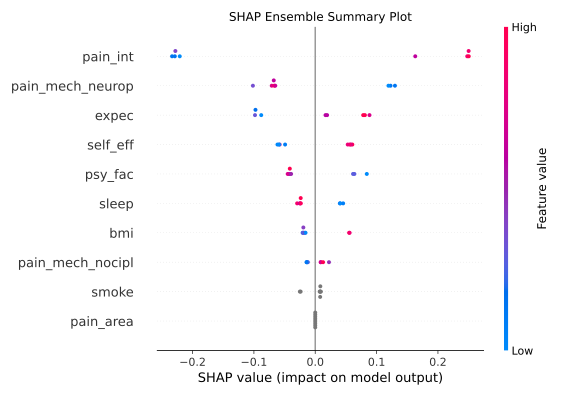

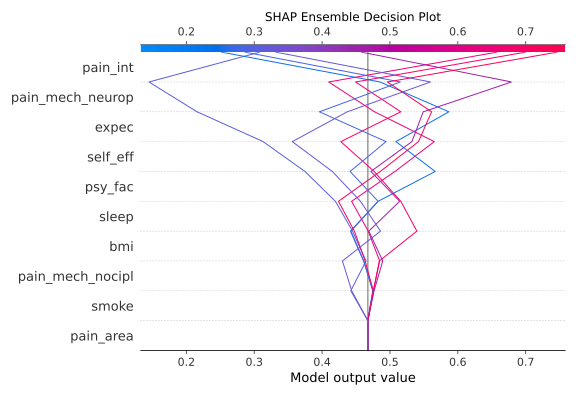

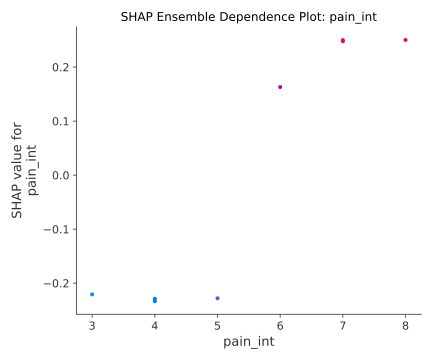

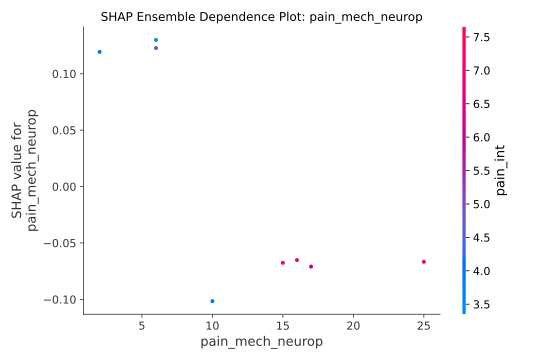

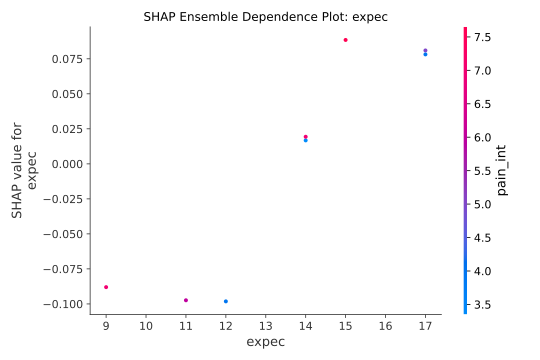

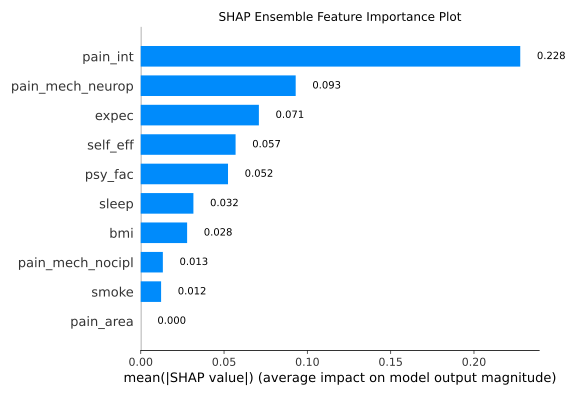

In [44]:
results = ensemble_runner.evaluate_ensemble(
    best_trial=ensemble_result["best_trial"],
    holdout_X=holdout_X,
    holdout_y=holdout_y,
    final_features=final_features,
    create_dataset=create_dataset
)

print(results["report"])  # Optional: check classification report

visualize_ensemble_results(results, final_features, config, rng)